# Fruit Classification using Convolutional Neural Network (CNN)
Developed By: Aiden WangYang Li  
Data Source: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition  
This file is mainly focusing on Hyperparameter Tuning, for Data Augmentation and Feature Analysis, please refer to the other file.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
from torchsummary import summary
from sklearn.model_selection import train_test_split
from PIL import Image
import time


## Import Fruit Image Dataset

In [2]:
# load data from NPZ
dataset = np.load('fruit_train.npz')
# tuple (string(fruit_name), array(images (#, 100, 100, 3)))

# print a summary of the dataset
for fruit in dataset.files:
    images = dataset[fruit]
    print(f"{fruit}: {images.shape}")

Apple Braeburn: (492, 100, 100, 3)
Apple Granny Smith: (492, 100, 100, 3)
Apricot: (492, 100, 100, 3)
Avocado: (427, 100, 100, 3)
Banana: (490, 100, 100, 3)
Blueberry: (462, 100, 100, 3)
Cactus fruit: (490, 100, 100, 3)
Cantaloupe: (492, 100, 100, 3)
Cherry: (492, 100, 100, 3)
Clementine: (490, 100, 100, 3)
Corn: (450, 100, 100, 3)
Cucumber Ripe: (392, 100, 100, 3)
Grape Blue: (984, 100, 100, 3)
Kiwi: (466, 100, 100, 3)
Lemon: (492, 100, 100, 3)
Limes: (490, 100, 100, 3)
Mango: (490, 100, 100, 3)
Onion White: (438, 100, 100, 3)
Orange: (479, 100, 100, 3)
Papaya: (492, 100, 100, 3)
Passion Fruit: (490, 100, 100, 3)
Peach: (492, 100, 100, 3)
Pear: (696, 100, 100, 3)
Pepper Green: (444, 100, 100, 3)
Pepper Red: (666, 100, 100, 3)
Pineapple: (490, 100, 100, 3)
Plum: (447, 100, 100, 3)
Pomegranate: (492, 100, 100, 3)
Potato Red: (450, 100, 100, 3)
Raspberry: (490, 100, 100, 3)
Strawberry: (492, 100, 100, 3)
Tomato: (738, 100, 100, 3)
Watermelon: (475, 100, 100, 3)


## Visualize Fruit Data

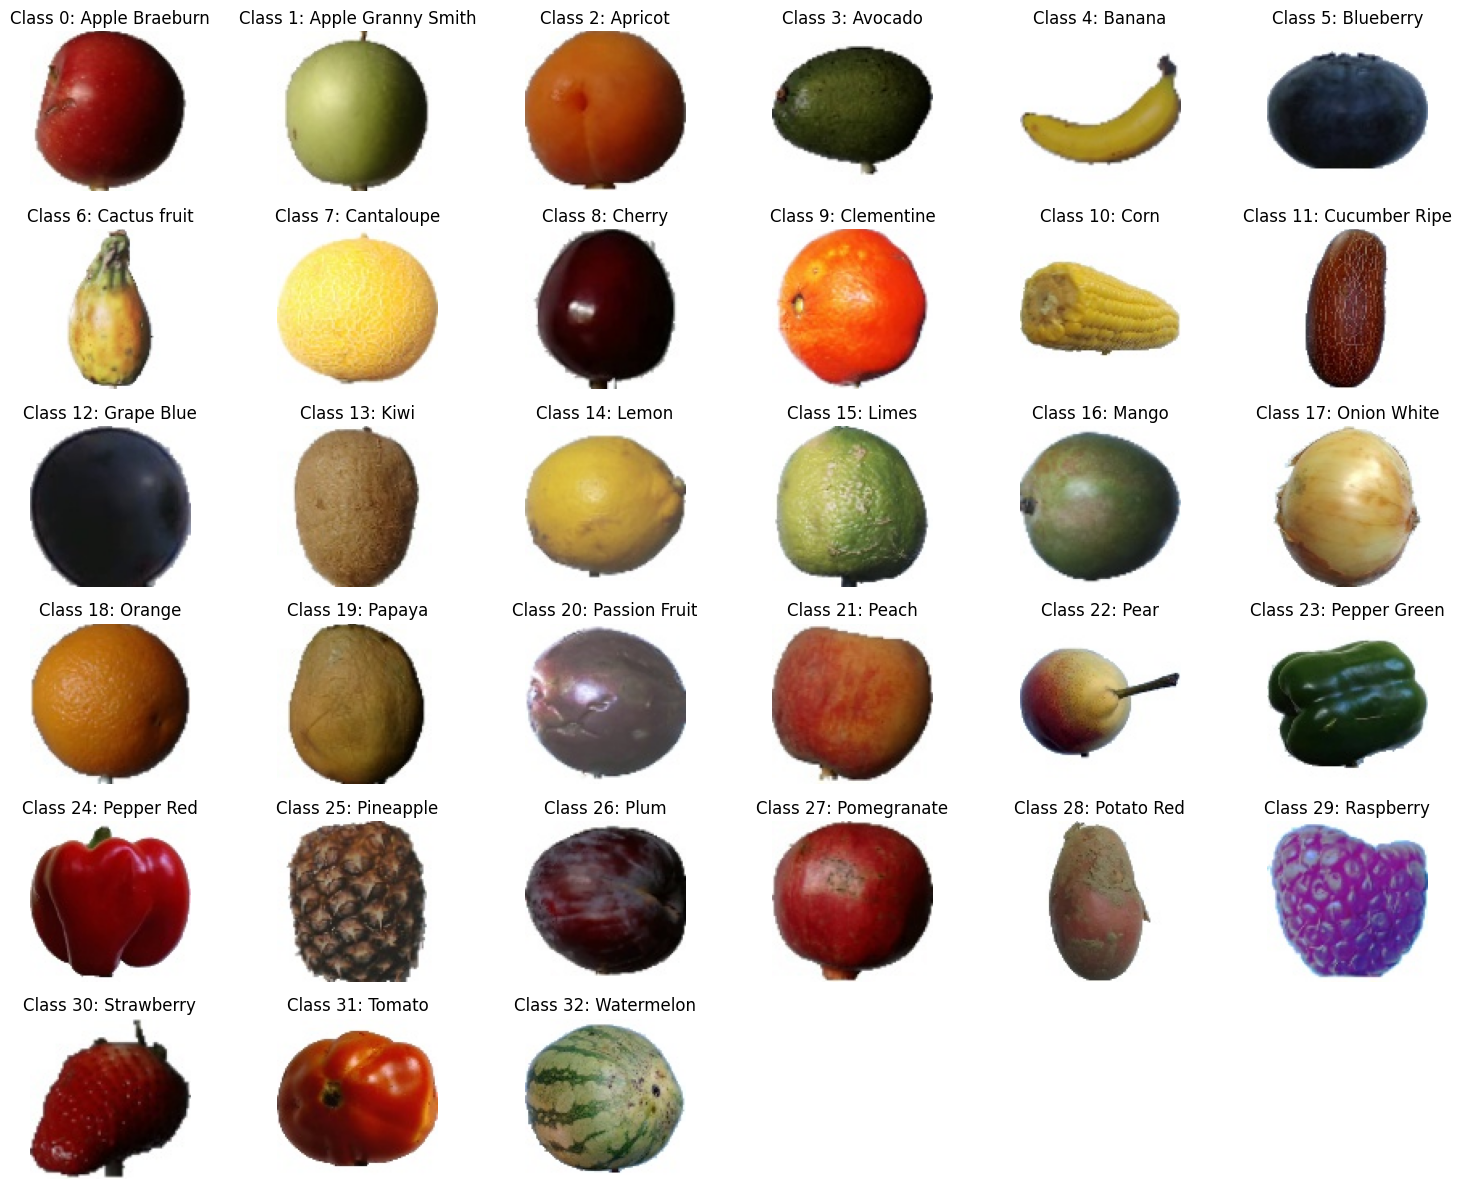

In [3]:
# Plot a preview of the dataset
num_classes = len(dataset)

# Calculate grid size for subplots
cols = 6  # You can change the number of columns based on your preference
rows = np.ceil(num_classes / cols).astype(int)

# Create a figure with subplots
plt.figure(figsize=(cols * 2.5, rows * 2))  # Adjust the size as needed

for i, (class_name, images) in enumerate(dataset.items(), 1):
    randidx = np.random.choice(len(images)) # select a random picture
    plt.subplot(rows, cols, i)
    plt.imshow(images[randidx])  # Plot the first image of each class
    plt.title("Class %d: %s" % (i-1, class_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

## Manage Dataset

In [4]:
''' 
Format the dataset structure from npz format to an array of images, and an array of labels
Input: Npz format dataset: tuple (string(fruit_name), array(images (#, 100, 100, 3)))
Output: Numpy nd-array Images (#, 100, 100, 3), Numpy nd-array labels (#)
'''
def formatData(dataset):
    # Get the fruit names from the dataset in a list format
    fruit_names = np.asarray(dataset.files)
    # Get the image shape
    image_shape = dataset[fruit_names[0]][0].shape

    # Initialize empty arrays for storing fruit images and labels
    fruit_images = np.empty((0, *image_shape), dtype=np.uint8)
    fruit_labels = np.empty(0, dtype=np.int64)
    # fruit_dict = {}

    # Manage the data of fruit names and fruit images
    for fruit_name, images in dataset.items():
        # Merge all the fruit images into one 4D numpy array
        fruit_images = np.concatenate((fruit_images, images), axis=0)
        # Get how many pictures there are of the current fruit, fill up the fruit index, 
        fruit_index = np.where(fruit_names == fruit_name)[0][0]
        current_fruit_labels = np.full(len(images), fruit_index) 
        # Append the fruit index with the number of pictures
        fruit_labels = np.append(fruit_labels, current_fruit_labels)

    # Format the data to tensor readable version (# of Image, width, hight, channels) to (# of Image, channels, width, hight)
    # Before: (16854, 100, 100, 3), After: (16854, 3, 100, 100)
    fruit_images = np.transpose(fruit_images, (0, 3, 1, 2))

    return fruit_images, fruit_labels, fruit_names

''' 
Get how many images for each fruit from the dataset
Input: Npz format dataset: tuple (string(fruit_name), array(images (#, 100, 100, 3))), # of image for each image
Output: Numpy nd-array Images (#, 100, 100, 3), Numpy nd-array labels (#)
'''
def getFixedNumberOfImageData(dataset, data_size):
    # Get the fruit names from the dataset in a list format
    fruit_names = np.asarray(dataset.files)
    # Get the image shape
    image_shape = dataset[fruit_names[0]][0].shape

    # Initialize empty arrays for storing fruit images and labels
    fruit_images = np.empty((0, *image_shape), dtype=np.uint8)
    fruit_labels = np.empty(0, dtype=np.int64)
    # fruit_dict = {}

    # Manage the data of fruit names and fruit images
    for fruit_name, images in dataset.items():
        # Set a random seed for reproducibility
        np.random.seed(42)
        # Randomly select input number of samples from the combined data without replacement
        indices = np.random.choice(len(images), size=data_size, replace=False)
        images = images[indices]
        # Merge all the fruit images into one 4D numpy array
        fruit_images = np.concatenate((fruit_images, images), axis=0)
        # Get how many pictures there are of the current fruit, fill up the fruit index, 
        fruit_index = np.where(fruit_names == fruit_name)[0][0]
        current_fruit_labels = np.full(len(images), fruit_index) 
        # Append the fruit index with the number of pictures
        fruit_labels = np.append(fruit_labels, current_fruit_labels)

    # Format the data to tensor readable version (# of Image, width, hight, channels) to (# of Image, channels, width, hight)
    # Before: (16854, 100, 100, 3), After: (16854, 3, 100, 100)
    fruit_images = np.transpose(fruit_images, (0, 3, 1, 2))

    return fruit_images, fruit_labels, fruit_names


''' 
Adjust Data Size for Faster Computing (Optional) 
Input: Numpy nd-array images, Numpy nd-array labels, size of the data you want to keep
Output: Numpy nd-array images, Numpy nd-array labels 
'''  
def resizeData(data: np.ndarray, labels: np.ndarray, data_size: int):
    # Set a random seed for reproducibility
    np.random.seed(42)
    # Randomly select input number of samples from the combined data without replacement
    indices = np.random.choice(len(data), size=data_size, replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

''' 
Normalize the image data to a range of [0 1]
Input: Numpy nd-array images
Output: Numpy nd-array images 
'''
def normalizeData(data: np.ndarray):
    data = data / np.max(data)
    return data

''' 
Convert data to tensor format, split data into train, test sets, then load all the data into TensorDataset
Input: Numpy nd-array images, Numpy nd-array labels
Output: TensorDataset(Training images, labels), TensorDataset(Testing images, labels)
'''
def createTensorDataset(fruit_images: np.ndarray, fruit_labels: np.ndarray):
    ## Create train/test groups using DataLoader
    # Step 1: convert to tensor
    dataT   = tc.tensor( fruit_images ).float()
    labelsT = tc.tensor( fruit_labels ).long()

    # Step 2: use scikitlearn to split the data
    train_data,test_data,train_labels,test_labels = train_test_split(dataT, labelsT, test_size=0.2,random_state=42)

    # Step 3: convert into PyTorch Datasets
    train_dataset = TensorDataset(train_data,train_labels)
    test_dataset  = TensorDataset(test_data,test_labels)
    return train_dataset, test_dataset

''' 
Convert data to DataLoader format, with a specific batch size
Input: TensorDataset(Train Set), TensorDataset(Test Set), batch size
Output: DataLoader(Train Set), DataLoader(Test Set)
'''
def createDataLoaderInBatch(train_dataset, test_dataset, batchsize):
    # Step 4: translate into dataloader objects
    train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
    return train_loader, test_loader


''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
# fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, 3000)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

 fruit_names = np.asarray([  
     'Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry',  
     'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya',  
     'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry',  
     'Strawberry', 'Tomato', 'Watermelon'])

## Simple Fruit Image Display Check

(3, 100, 100)
(100, 100, 3)


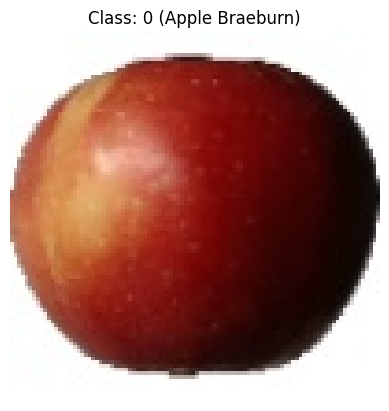

In [5]:
index = 2 # change the fruit index here to get a different fruit image (from 0 to 16853)
image = fruit_images[index]
label_idx = fruit_labels[index]
label_name = fruit_names[label_idx]
print(image.shape)
image = np.transpose(image, (1, 2, 0))
# image = image.permute(1, 2, 0)
print(image.shape)

# Display the image
plt.imshow(image)
plt.title(f"Class: {label_idx} ({label_name})")
plt.axis('off')
plt.show()

## Define CNN Deep Learning Model

In [6]:
# Create a class for a simple CNN model
class fruitCNN(nn.Module):
    def __init__(self,printtoggle: bool, kernel: int, stride: int, padding:int ,inChannel: int, outClass: int, imgsize: int, poolKernel: int):
        super().__init__()
        self.outChannel = [10, 20]
        self.poolKernel = poolKernel
        self.node = 50

        ### convolution layers
        self.conv1 = nn.Conv2d(inChannel,self.outChannel[0],kernel,stride,padding)
        # size1: np.floor( (100+2*1-5)/1 )+1 = 98/2 = 48 (/2 b/c maxpool)
        size1 = np.floor(((imgsize+2*padding-kernel)/stride + 1)/poolKernel)
        self.conv2 = nn.Conv2d(self.outChannel[0],self.outChannel[1],kernel,stride,padding)
        # size2: np.floor( (49+2*1-5)/1 )+1 = 47/2 = 23 (/2 b/c maxpool)
        size2 = np.floor(((size1+2*padding-kernel)/stride + 1)/poolKernel)
        
        # Total number of pixels in the last layer: # of output channel * (width * height)
        expectSize = self.outChannel[1]*int(size2**2)

        ### fully-connected layer
        self.fc1 = nn.Linear(expectSize,self.node)
        ### output layer
        self.out = nn.Linear(self.node,outClass)

        # toggle for printing out tensor sizes during forward prop
        self.print = printtoggle

    # forward pass
    def forward(self,x):
        
        print(f'Input: {x.shape}') if self.print else None

        # convolution -> maxpool -> relu
        x = F.relu(F.max_pool2d(self.conv1(x),self.poolKernel))
        print(f'Layer conv1/pool1: {x.shape}') if self.print else None

        # and again: convolution -> maxpool -> relu
        x = F.relu(F.max_pool2d(self.conv2(x),self.poolKernel))
        print(f'Layer conv2/pool2: {x.shape}') if self.print else None

        # reshape for linear layer
        nUnits = x.shape.numel()/x.shape[0]
        x = x.view(-1,int(nUnits))
        if self.print: print(f'Vectorize: {x.shape}')
        
        # linear layers
        x = F.relu(self.fc1(x))
        if self.print: print(f'Layer fc1: {x.shape}')
        x = self.out(x)
        if self.print: print(f'Layer out: {x.shape}')

        return x
    

# Create a class for a customizable CNN model
class fruitCNN_Customizable(nn.Module):
    def __init__(self,printtoggle: bool, params: dict):
        super().__init__()

        # Initialize default parameters
        self.inChannel = params["inChannel"]            # Input channels (RGB 3 channels for images)
        self.outClass = params["outClass"]              # Output class (fruit category)
        self.imgsize = params["imgsize"]                # Image size (100 x 100)
        self.fc_config = params["fc_config"]            # Fully-connected layer structure
        self.pooling_ker = params["pooling_kernel"]     # Pooling kernel size
        self.pooling_func = F.avg_pool2d if params["pooling"] == 'ave' else F.max_pool2d    # Pooling Function (avg-pool or  max-pool)
        self.conv_dropout = nn.Dropout2d(params["dropout_rate"]) # Dropout for convolutional layers
        
        ### Initialze customizable convolution layers
        self.conv = nn.ModuleDict() # Create a dictionary to store the convolution layers.
        for i in range(len(params["feature"])):
            outChannel = params["feature"][i]
            kernel = params["kernel"][i]
            stride = params["stride"][i]
            padding = params["padding"][i]
            # nn.Conv2d(inChannel,outChannel,kernel,stride,padding)
            self.conv[f'conv{i}'] = nn.Conv2d(self.inChannel, outChannel, kernel, stride, padding)
            self.inChannel = outChannel
            # Compute the image size of new layer 
            self.imgsize = np.floor(((self.imgsize+2*padding-kernel)/stride + 1)/self.pooling_ker)
        
        # Total number of pixels in the last layer: # of output channel * (width * height)
        self.fcInLayer = params["feature"][-1]*int(self.imgsize**2)

        ### Initialze customizable fully-connected layer
        self.fc = nn.ModuleDict() # Create a dictionary to store the fully-connected layers.
        for i in range(len(params["fc_config"])):
            fcOutLayer = self.fc_config[i]
            self.fc[f'fc{i}'] = nn.Linear(self.fcInLayer,fcOutLayer)
            self.fcInLayer = fcOutLayer
        ### output layer
        self.out = nn.Linear(self.fcInLayer,self.outClass)

        # toggle for printing out tensor sizes during forward prop
        self.print = printtoggle

    # forward pass
    def forward(self,x):
        
        print(f'Input: {x.shape}') if self.print else None

        # Hidden layers with ReLU activation.
        for i in range(len(self.conv)):
            x = F.relu(self.pooling_func(self.conv[f'conv{i}'](x),self.pooling_ker))
            x = self.conv_dropout(x)  # Apply dropout after pooling
            print(f'Layer conv{i}/pool{i}: {x.shape}') if self.print else None

        # reshape for linear layer
        x = x.view(x.size(0), -1)
        if self.print: print(f'Vectorize: {x.shape}')
        
        # linear layers
        for i in range(len(self.fc)):
             x = F.relu(self.fc[f'fc{i}'](x))
             if self.print: print(f'Layer fc{i}: {x.shape}')
        x = self.out(x)
        if self.print: print(f'Layer out: {x.shape}')

        return x


## Test the model with one batch

In [7]:
# Input parameters for the simple CNN model
# inChannel   = 3
# outChannel  = 33
# imsize      = 100
# kernel      = 7
# stride      = 2
# padding     = 1
# poolKernel  = 2
# learning_rate = 0.001

# # create the model instance
# cnn = fruitCNN(True,kernel,stride,padding,inChannel,outChannel,imsize,poolKernel)
# # loss function
# lossfun = nn.CrossEntropyLoss()
# # optimizer
# optimizer = tc.optim.Adam(cnn.parameters(),lr=learning_rate)

# X,y = next(iter(train_loader))
# yHat = cnn(X)
# # check sizes of model outputs and target variable
# print(' ')
# print(yHat.shape)
# print(y.shape)

# # now let's compute the loss
# loss = lossfun(yHat,y)
# print(' ')
# print('Loss:')
# print(loss)
# print('\n--------------\n')

# Default configueration for the customizable CNN model
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32, 64],    # Convolutional layer (feature map, kernel_size, stride, padding)
    "kernel": [7, 5, 5],
    "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

# create the model instance
cnn = fruitCNN_Customizable(True,params)
# loss function
lossfun = nn.CrossEntropyLoss()
# optimizer
optimizer = tc.optim.Adam(cnn.parameters(),lr=0.001)

X,y = next(iter(train_loader))
yHat = cnn(X)
# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)


Input: torch.Size([32, 3, 100, 100])
Layer conv0/pool0: torch.Size([32, 16, 24, 24])
Layer conv1/pool1: torch.Size([32, 32, 11, 11])
Layer conv2/pool2: torch.Size([32, 64, 4, 4])
Vectorize: torch.Size([32, 1024])
Layer fc0: torch.Size([32, 50])
Layer out: torch.Size([32, 33])
 
torch.Size([32, 33])
torch.Size([32])
 
Loss:
tensor(3.5017, grad_fn=<NllLossBackward0>)


In [8]:
# count the total number of parameters in the model
summary(cnn, (3, 100, 100))

Input: torch.Size([2, 3, 100, 100])
Layer conv0/pool0: torch.Size([2, 16, 24, 24])
Layer conv1/pool1: torch.Size([2, 32, 11, 11])
Layer conv2/pool2: torch.Size([2, 64, 4, 4])
Vectorize: torch.Size([2, 1024])
Layer fc0: torch.Size([2, 50])
Layer out: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,368
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6             [-1, 64, 4, 4]               0
            Linear-7                   [-1, 50]          51,250
            Linear-8                   [-1, 33]           1,683
Total params: 119,397
Trainable params: 119,397
Non-trainable params: 0
-----------------

## Train CNN Deep Learning Model

In [10]:
# a function that trains the model
def trainCNNModel(cnn: fruitCNN, train_loader: DataLoader, test_loader: DataLoader, numepochs: int, learning_rate: float, optimizer_type: str):

    # Specify the Loss function and optimizer
    lossfun = nn.CrossEntropyLoss()                 # Cross-entropy loss for classification.
    optifun = getattr(tc.optim, optimizer_type)     # Specify the optimizer
    optimizer = optifun(cnn.parameters(), lr=learning_rate)  
    
    # Initialize lists to store training statistics
    losses = []     # To store losses at each epoch
    trainAcc = []   # To store training accuracies
    testAcc = []    # To store test accuracies

    # loop over epochs
    for epochi in range(numepochs):
        # Switch on training mode for the neural network
        cnn.train()
        # Initialize lists to store batch-wise training statistics
        batchAcc = []    # To store batch accuracies
        batchLoss = []   # To store batch losses

        for train_data,train_labels in train_loader:
            train_labels = tc.squeeze(train_labels)
            # forward pass and loss
            yHat = cnn(train_data)
            loss = lossfun(yHat,train_labels)

            # Backpropagation
            optimizer.zero_grad()  # Zero out gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update model parameters using the optimizer

            # Store the loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = tc.argmax(yHat,axis=1) == train_labels    # booleans (false/true)
            matchesNumeric = matches.float()                    # convert to numbers (0/1)
            accuracyPct = 100*tc.mean(matchesNumeric)           # average and x100
            batchAcc.append( accuracyPct )                      # add to list of accuracies

        # Calculate and store the average training accuracy across all mini-batches for this epoch.
        trainAcc.append(np.mean(batchAcc))
        # Calculate and store the average loss across all mini-batches for this epoch.
        losses.append(np.mean(batchLoss))

        # Switch to evaluation mode (no gradient computation)
        cnn.eval()
        test_data,test_labels = next(iter(test_loader)) # extract X,y from test dataloader
        with tc.no_grad(): # deactivates autograd
            yHat = cnn(test_data)
            test_labels = tc.squeeze(test_labels)
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*tc.mean((tc.argmax(yHat,axis=1)==test_labels).float()) )

    # Function output: Returns ongoing training accuracies, ongoing test accuracies, and losses
    return trainAcc,testAcc,losses,cnn


## Run the simple model and show the results!

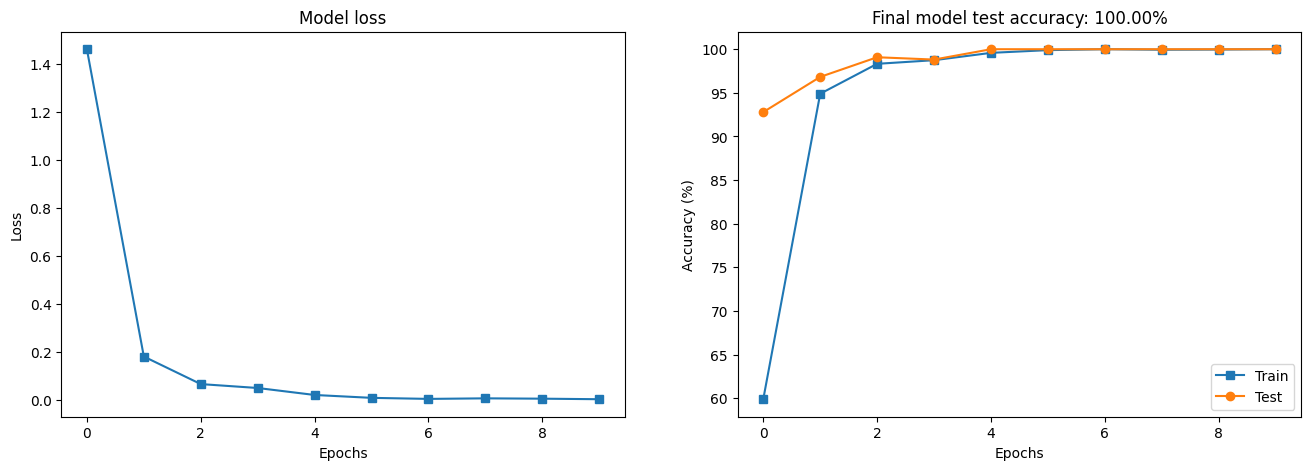

In [12]:
# Input parameters
imageCount  = 3000  # Change the number of images here (Uncomment the Resize Data section)
inChannel   = 3     # fixed value
outChannel  = 33    # fixed value
imgsize     = 100   # fixed value
kernel      = 7     # adjustable
stride      = 2     # adjustable
padding     = 1     # adjustable
poolKernel  = 2     # adjustable
batchsize   = 128   # adjustable
numepochs   = 10    # adjustable
learning_rate = 0.001    # adjustable
optimizer = 'Adam'

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
# fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

''' Create a new model '''
cnn = fruitCNN(False,kernel,stride,padding,inChannel,outChannel,imgsize,poolKernel)
''' Train CNN model '''
trainAcc,testAcc,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)

''' Plot the result '''
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Fine-tune the HyperParameters

### Find the Optimal Loss Function
We decide to use the Cross Entropy Loss function, as it suits our multi-class classification problem.

### Find the Optimal Activation Function for Hidden Convolutional Layers
We decide to use the ReLu as the default one.

### Find the Optimal Mini-Batch Number

Batch #  Average Train Accuracy   Final Train Accuracy     Average Test Accuracy    Final Test Accuracy      Process Time            
32       95.83%                   99.54%                   99.36%                   99.25%                   257.03 Seconds          
64       93.90%                   99.41%                   98.47%                   99.96%                   226.94 Seconds          
128      93.15%                   99.62%                   97.91%                   100.00%                  208.75 Seconds          
256      90.68%                   99.68%                   96.36%                   99.96%                   202.02 Seconds          
512      83.63%                   99.06%                   90.45%                   99.79%                   196.67 Seconds          


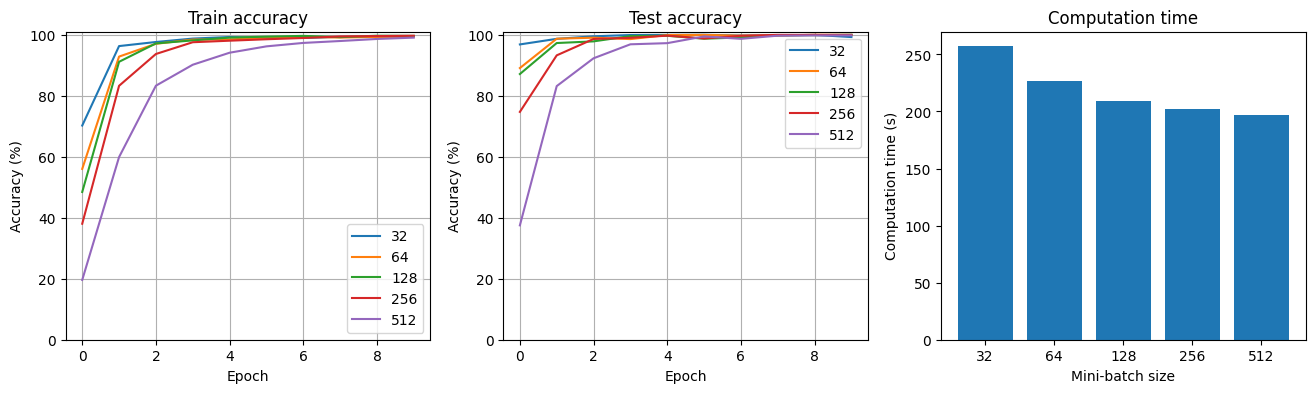

In [ ]:
# Input parameters
imageCount  = 12000 # Change the number of images here  (Uncomment the Resize Data section)
numepochs   = 10    # adjustable
learning_rate = 0.001    # adjustable
optimizer = 'Adam'
# Range of batch sizes  
batchsizes = 2 ** np.arange(5, 10, 1) # (32, 64, 128, 256, 512)

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32],    # Convolutional layer (feature map, kernel_size, stride, padding)    
    "kernel": [7, 5],    
    "stride": [2, 1],
    "padding": [1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)

# Create empty matrices to store training and testing accuracies, as well as computation times.
averageTrainAcc = np.zeros((numepochs, len(batchsizes)))
averageTestAcc = np.zeros((numepochs, len(batchsizes)))
finalTrainAcc = np.zeros(len(batchsizes))
finalTestAcc = np.zeros(len(batchsizes))
comptime = np.zeros(len(batchsizes))

# Create a DataLoader for the test data. It has a batch size equal to the total number of samples in the test dataset.
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# Loop over different batch sizes
for bi in range(len(batchsizes)):

    # Start the timer to measure computation time
    starttime = time.process_time()

    # Create DataLoader object for training data with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=False)
    # Create a DataLoader for training data with the current batch size.
    # - 'int(batchsizes[bi])': Converts the current batch size to an integer.
    # - 'shuffle=True': Shuffles the training data.
    # - 'drop_last=True': Drops the last batch if it's smaller than the specified batch size.

    # Create and train a model
    cnn = fruitCNN_Customizable(False,params)
    # Train the model and obtain training statistics
    trainAccList,testAccList,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
    finalTrainAcc[bi] = trainAccList[-1]
    finalTestAcc[bi] = testAccList[-1]
    # Store training and testing accuracy results
    averageTrainAcc[:, bi] = trainAccList
    averageTestAcc[:, bi] = testAccList

    # Record the computation time
    comptime[bi] = time.process_time() - starttime

# Print the overall accuracy for each batch
meanTrainAcc = np.mean(averageTrainAcc, axis=0)
meanTestAcc = np.mean(averageTestAcc, axis=0)


print("{:<8} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
    "Batch #", "Average Train Accuracy", "Final Train Accuracy", "Average Test Accuracy", "Final Test Accuracy", "Process Time"))
for i, batch in enumerate(batchsizes):
    print("{:<8} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
        batchsizes[i], 
        "%.2f%%" % (meanTrainAcc[i]), "%.2f%%" % (finalTrainAcc[i]), 
        "%.2f%%" % (meanTestAcc[i]), "%.2f%%" % (finalTestAcc[i]), "%.2f Seconds" % (comptime[i])))

# plot some results
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(averageTrainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(averageTestAcc)
ax[1].set_title('Test accuracy')
ax[2].bar(np.arange(0, len(comptime), 1, dtype=int),comptime,tick_label=batchsizes)
ax[2].set_xlabel('Mini-batch size')
ax[2].set_ylabel('Computation time (s)')
ax[2].set_title('Computation time')

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([0,101])
    ax[i].grid()
plt.show()


From the above plots, we can see that the best mini-batch size option is 128. It has lower computation time and highest accuracy on a stable prediction trend.  

### Find the Optimal Optimizer and Learning Rate

Using Optimizer SGD
 > Learning rate with highest accuracy: 0.054
 > Maximum Training Accuracy: 52.21
 > Maximum Testing Accuracy:  57.83
Using Optimizer RMSprop
 > Learning rate with highest accuracy: 0.001
 > Maximum Training Accuracy: 94.31
 > Maximum Testing Accuracy:  96.83
Using Optimizer Adam
 > Learning rate with highest accuracy: 0.001
 > Maximum Training Accuracy: 96.74
 > Maximum Testing Accuracy:  98.33
Using Optimizer Adadelta
 > Learning rate with highest accuracy: 0.895
 > Maximum Training Accuracy: 94.40
 > Maximum Testing Accuracy:  97.33


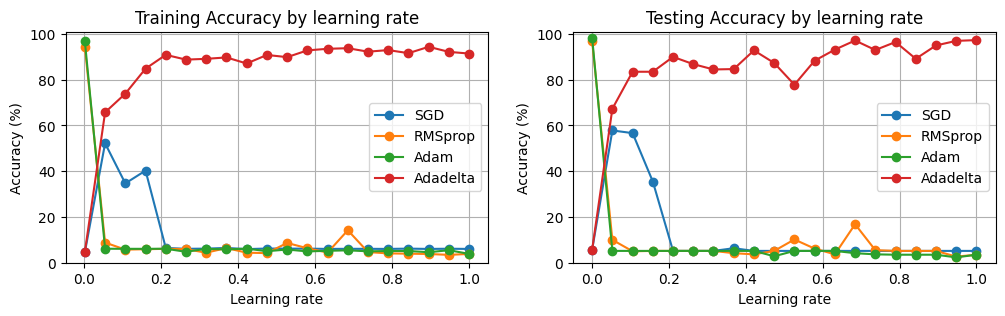

In [14]:
# Input parameters
imageCount  = 3000  # Change the number of images here
numepochs   = 10    # adjustable
batchsize   = 128   # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32],# Convolutional layer (feature map, kernel_size, stride, padding)    
    "kernel": [7, 5],    
    "stride": [2, 1],
    "padding": [1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

lr_start = 0.001        # The staring value of the learning rate
lr_end = 1              # The ending value of the learning rate
lr_num = 20             # The number of learning rates show on the plots
# Test on learning  rate
learningrates = np.linspace(lr_start,lr_end,lr_num)
optList = ['SGD', 'RMSprop', 'Adam', 'Adadelta']

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

# Create empty matrices to store training and testing accuracies, as well as computation times.
averageTrainAcc = np.zeros((numepochs, len(optList)))
averageTestAcc = np.zeros((numepochs, len(optList)))
finalTrainAcc = np.zeros(len(optList))
finalTestAcc = np.zeros(len(optList))
comptime = np.zeros(len(optList))

fig,ax = plt.subplots(1,2,figsize=(12,3))
# Loop through each optimizer
for i, optimizer in enumerate(optList):
    print("Using Optimizer " + optimizer)
    # initialize
    trainaccByLR = []
    testaccByLR = []
    highestTrainAcc = 0
    best_lr = 0

    # Loop through learning rate range
    for i ,lr in enumerate(learningrates):
        
        # create and run the model
        cnn = fruitCNN_Customizable(False,params)
        trainAccList,testAccList,losses,trained_cnn =\
              trainCNNModel(cnn, train_loader, test_loader, numepochs, lr, optimizer)
        # get the last/optimal accuracy from the list
        finalTrainAcc = trainAccList[-1]
        finalTestAcc = testAccList[-1]
        # store the final accuracy of each
        trainaccByLR.append(finalTrainAcc)
        testaccByLR.append(finalTestAcc)

        if finalTrainAcc > highestTrainAcc: 
            highestTrainAcc = finalTrainAcc 
            best_lr = lr

    # plot the results
    print(" > Learning rate with highest accuracy: %.3f" % best_lr)
    print(" > Maximum Training Accuracy: %.2f" % np.max(trainaccByLR, axis=0))
    print(" > Maximum Testing Accuracy:  %.2f" % np.max(testaccByLR, axis=0))

    ax[0].plot(learningrates,trainaccByLR,'o-')
    ax[1].plot(learningrates,testaccByLR,'o-')
    
# common features
ax[0].set_title('Training Accuracy by learning rate')
ax[0].set_ylim([0,101])
ax[1].set_title('Testing Accuracy by learning rate')
ax[1].set_ylim([0,101])
for i in range(2):
    ax[i].legend(optList)
    ax[i].set_xlabel('Learning rate')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([0,101])
    ax[i].grid()
plt.show()


Adam is the best option with the highest average training accuracy.

### Find the Optimal Number of Epoch for Optimizer

Optimizer #  Average Train Accuracy   Final Train Accuracy     Average Test Accuracy    Final Test Accuracy      Process Time            
SGD          42.51%                   81.42%                   42.69%                   87.67%                   115.27 Seconds          
RMSprop      69.49%                   94.97%                   76.18%                   97.33%                   114.34 Seconds          
Adam         81.22%                   98.31%                   85.14%                   97.67%                   114.97 Seconds          
Adadelta     73.83%                   96.57%                   76.63%                   96.83%                   114.48 Seconds          


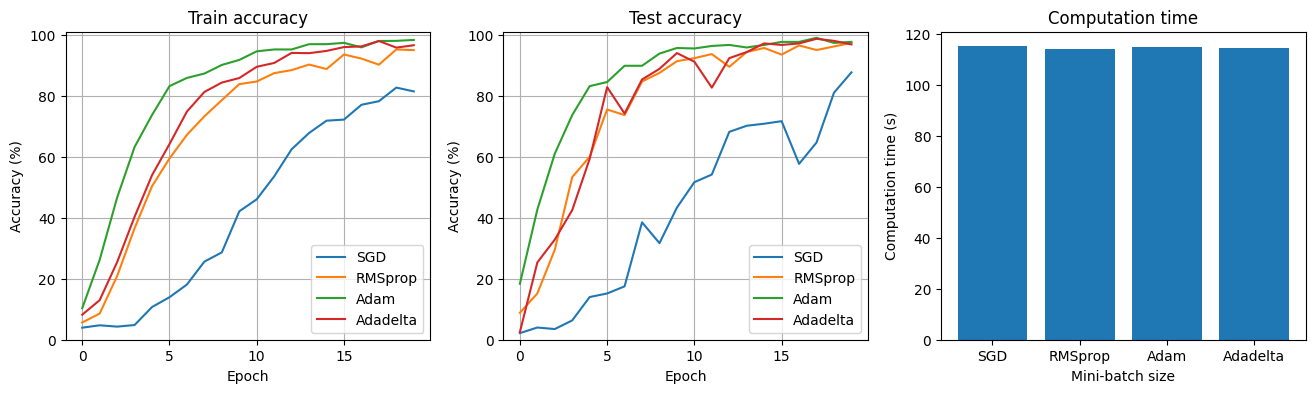

In [17]:
# Set the hyperparameters
# Input parameters
imageCount  = 3000  # Change the number of images here
numepochs   = 20    # adjustable
batchsize   = 128   # adjustable
optList = ['SGD', 'RMSprop', 'Adam', 'Adadelta']
lrList = [0.05, 0.001, 0.001, 0.5]

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32, 64],# Convolutional layer (feature map, kernel_size, stride, padding)    
    "kernel": [7, 5, 5],    
    "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

# Create empty matrices to store training and testing accuracies, as well as computation times.
averageTrainAcc = np.zeros((numepochs, len(optList)))
averageTestAcc = np.zeros((numepochs, len(optList)))
finalTrainAcc = np.zeros(len(optList))
finalTestAcc = np.zeros(len(optList))
comptime = np.zeros(len(optList))

for bi, optimizer in enumerate(optList):
    learning_rate = lrList[bi]

    # Start the timer to measure computation time
    starttime = time.process_time()

    # Create a new model
    cnn = fruitCNN_Customizable(False,params)
    # Train the model and obtain training statistics
    trainAccList,testAccList,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
    finalTrainAcc[bi] = trainAccList[-1]
    finalTestAcc[bi] = testAccList[-1]
    # Store training and testing accuracy results
    averageTrainAcc[:, bi] = trainAccList
    averageTestAcc[:, bi] = testAccList

    # Record the computation time
    comptime[bi] = time.process_time() - starttime

# Print the overall accuracy for each batch
meanTrainAcc = np.mean(averageTrainAcc, axis=0)
meanTestAcc = np.mean(averageTestAcc, axis=0)

print("{:<12} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
    "Optimizer #", "Average Train Accuracy", "Final Train Accuracy", "Average Test Accuracy", "Final Test Accuracy", "Process Time"))
for i, batch in enumerate(optList):
    print("{:<12} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
        optList[i], 
        "%.2f%%" % (meanTrainAcc[i]), "%.2f%%" % (finalTrainAcc[i]), 
        "%.2f%%" % (meanTestAcc[i]), "%.2f%%" % (finalTestAcc[i]), "%.2f Seconds" % (comptime[i])))

# plot some results
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(averageTrainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(averageTestAcc)
ax[1].set_title('Test accuracy')
ax[2].bar(np.arange(0, len(comptime), 1, dtype=int),comptime,tick_label=optList)
ax[2].set_xlabel('Mini-batch size')
ax[2].set_ylabel('Computation time (s)')
ax[2].set_title('Computation time')

# common features
for i in range(2):
    ax[i].legend(optList)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([0,101])
    ax[i].grid()
plt.show()


### Find the Optimal Number of Kernel, Stride, and Paddings
Tagets: 2 or 3 Convolutional Layers with different combinations of Kernel and Stride

#### Kernel and Stride for First Two Convolutional Layers

Process Time: 37.265625


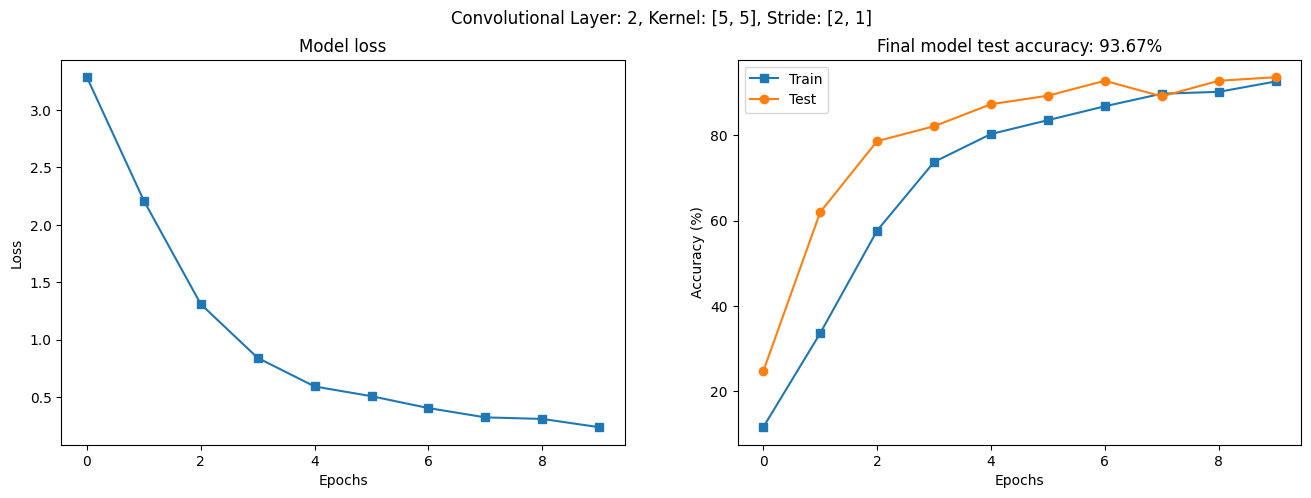

Process Time: 39.671875


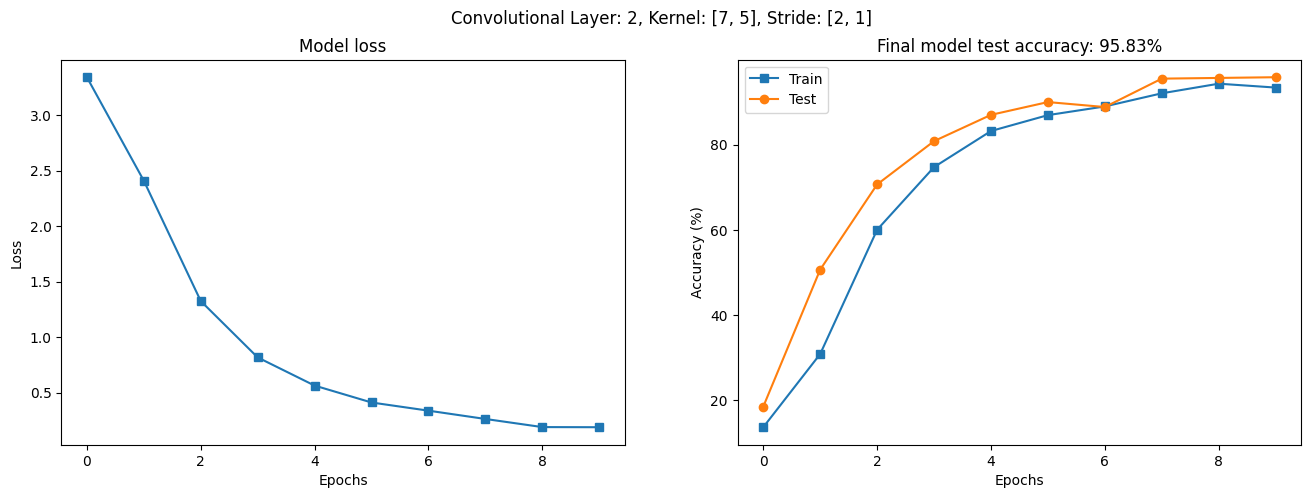

Process Time: 41.5625


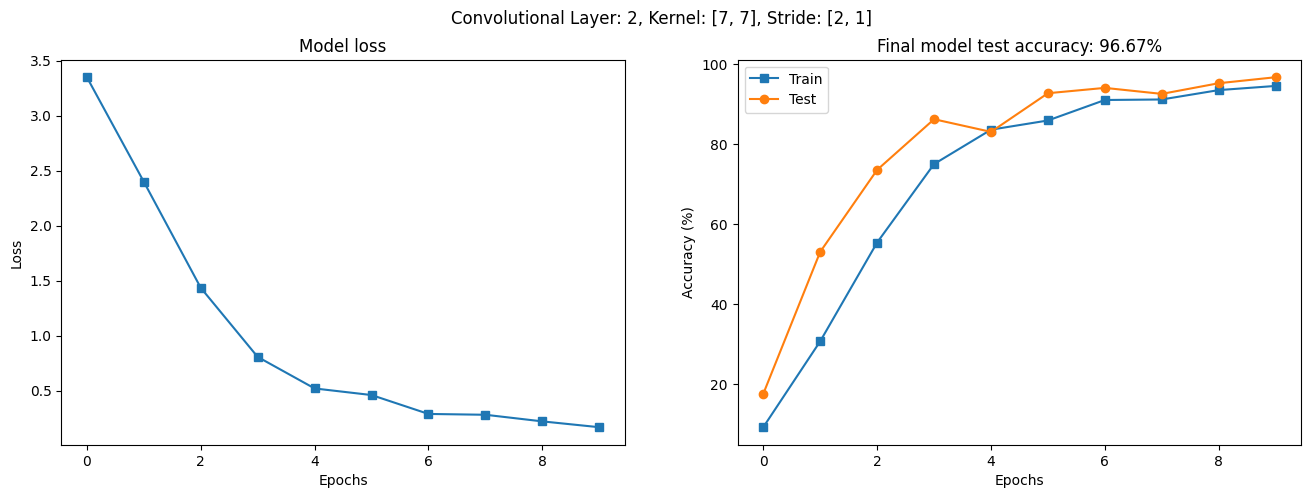

In [22]:
# Set the hyperparameters
# Input parameters
imageCount  = 3000  # Change the number of images here
batchsize   = 128   # adjustable
numepochs   = 10    # adjustable
learning_rate = 0.001   # adjustable
optimizer = 'Adam'  # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [10, 20],    # Convolutional layer (feature map, kernel_size, stride, padding)
    # "kernel": [7, 7],
    # "stride": [2, 1],
    "padding": [1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

# Test cases for different combinations of kernel and stride
cases = {
    # "0": { "kernel": [5, 5], "stride": [1, 1],},
    # "1": { "kernel": [5, 5], "stride": [1, 2],},
    "2": { "kernel": [5, 5], "stride": [2, 1],},
    # "3": { "kernel": [5, 5], "stride": [2, 2],},

    # "4": { "kernel": [5, 7], "stride": [1, 1],},
    # "5": { "kernel": [5, 7], "stride": [1, 2],},
    # "6": { "kernel": [5, 7], "stride": [2, 1],},
    # "7": { "kernel": [5, 7], "stride": [2, 2],},

    # "8": { "kernel": [7, 5], "stride": [1, 1],},
    # "9": { "kernel": [7, 5], "stride": [1, 2],},
    "10": { "kernel": [7, 5], "stride": [2, 1],},
    # "11": { "kernel": [7, 5], "stride": [2, 2],},

    # "12": { "kernel": [7, 7], "stride": [1, 1],},
    # "13": { "kernel": [7, 7], "stride": [1, 2],},
    "14": { "kernel": [7, 7], "stride": [2, 1],},
    # "15": { "kernel": [7, 7], "stride": [2, 2],},
}

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)


for test_case in cases.values():
    new_params = {**params, **test_case} # Merge the dictionary with current case
    conv_len = len(test_case['kernel'])
    kernel = test_case['kernel']
    stride = test_case['stride']
    starttime = time.process_time()
    ''' Create a new model '''
    cnn = fruitCNN_Customizable(False,new_params)
    ''' Train CNN model '''
    trainAcc,testAcc,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
    endtime = time.process_time() - starttime
    print("Process Time:", endtime)
    ''' Plot the result '''
    fig,ax = plt.subplots(1,2,figsize=(16,5))
    fig.suptitle("Convolutional Layer: %d, Kernel: %s, Stride: %s" % (conv_len, str(kernel), str(stride)))
    ax[0].plot(losses,'s-')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model loss')

    ax[1].plot(trainAcc,'s-',label='Train')
    ax[1].plot(testAcc,'o-',label='Test')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
    ax[1].legend()

    plt.show()


#### Kernel and Stride for The Third Convolutional Layer

Process Time: 41.421875


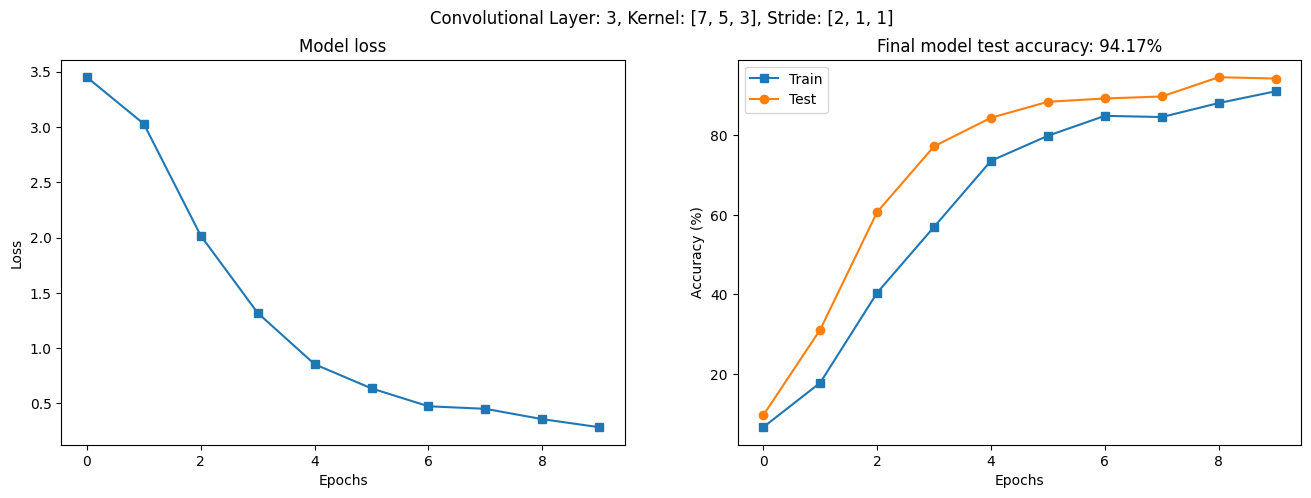

Process Time: 41.015625


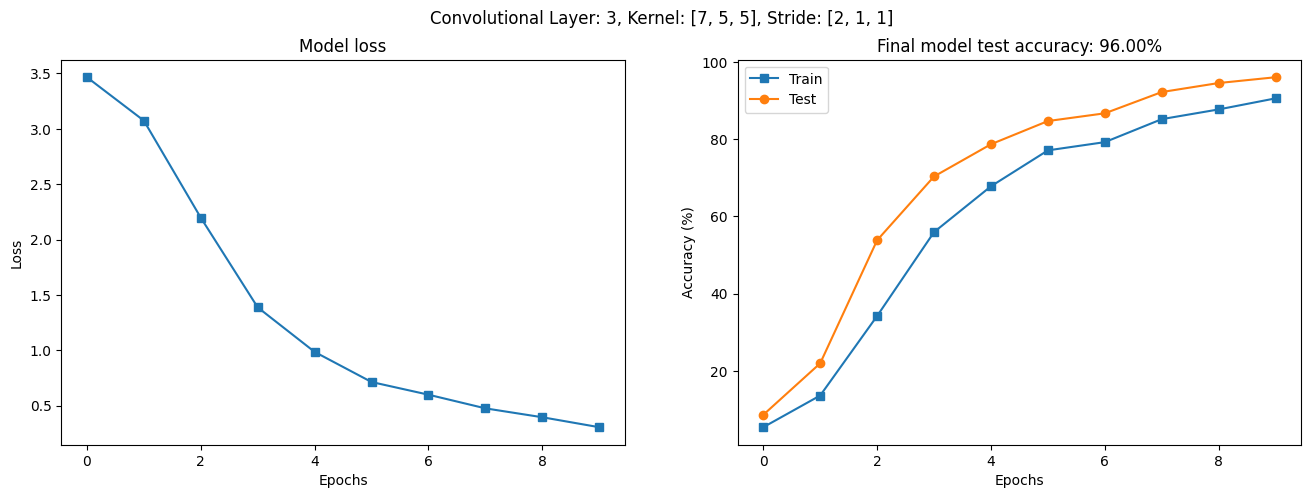

Process Time: 44.8125


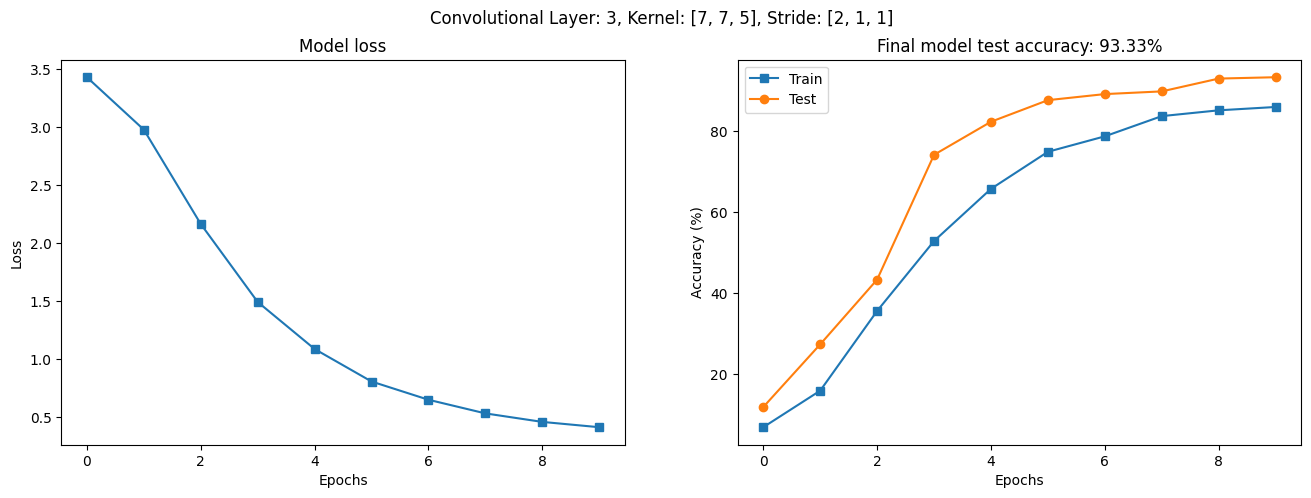

In [25]:
# Set the hyperparameters
# Input parameters
imageCount  = 3000  # Change the number of images here
batchsize   = 128   # adjustable
numepochs   = 10    # adjustable
learning_rate = 0.001   # adjustable
optimizer = 'Adam'  # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [10, 20, 30],    # Convolutional layer (feature map, kernel_size, stride, padding)
    # "kernel": [7, 7, 5],
    # "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

# Test cases for different combinations of kernel and stride
cases = {
    "0": { "kernel": [7, 5, 3], "stride": [2, 1, 1],},
    "1": { "kernel": [7, 5, 5], "stride": [2, 1, 1],},
    # "2": { "kernel": [7, 7, 3], "stride": [2, 1, 1],},
    "3": { "kernel": [7, 7, 5], "stride": [2, 1, 1],},
}

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)


for test_case in cases.values():
    new_params = {**params, **test_case} # Merge the dictionary with current case
    conv_len = len(test_case['kernel'])
    kernel = test_case['kernel']
    stride = test_case['stride']
    starttime = time.process_time()
    ''' Create a new model '''
    cnn = fruitCNN_Customizable(False,new_params)
    ''' Train CNN model '''
    trainAcc,testAcc,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
    endtime = time.process_time() - starttime
    print("Process Time:", endtime)
    ''' Plot the result '''
    fig,ax = plt.subplots(1,2,figsize=(16,5))
    fig.suptitle("Convolutional Layer: %d, Kernel: %s, Stride: %s" % (conv_len, str(kernel), str(stride)))
    ax[0].plot(losses,'s-')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model loss')

    ax[1].plot(trainAcc,'s-',label='Train')
    ax[1].plot(testAcc,'o-',label='Test')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
    ax[1].legend()

    plt.show()

### Find the Optimal Number of Feature Maps for Three Convolutional Layers

Feature Maps       Average Train Accuracy   Final Train Accuracy     Average Test Accuracy    Final Test Accuracy      Process Time            
[10, 20, 30]       58.74%                   88.28%                   70.02%                   93.67%                   42.67 Seconds           
[16, 32, 64]       70.59%                   94.44%                   78.68%                   95.83%                   56.94 Seconds           
[32, 64, 128]      75.36%                   96.74%                   81.85%                   98.17%                   135.14 Seconds          
[64, 128, 256]     76.05%                   97.22%                   81.45%                   98.67%                   381.70 Seconds          


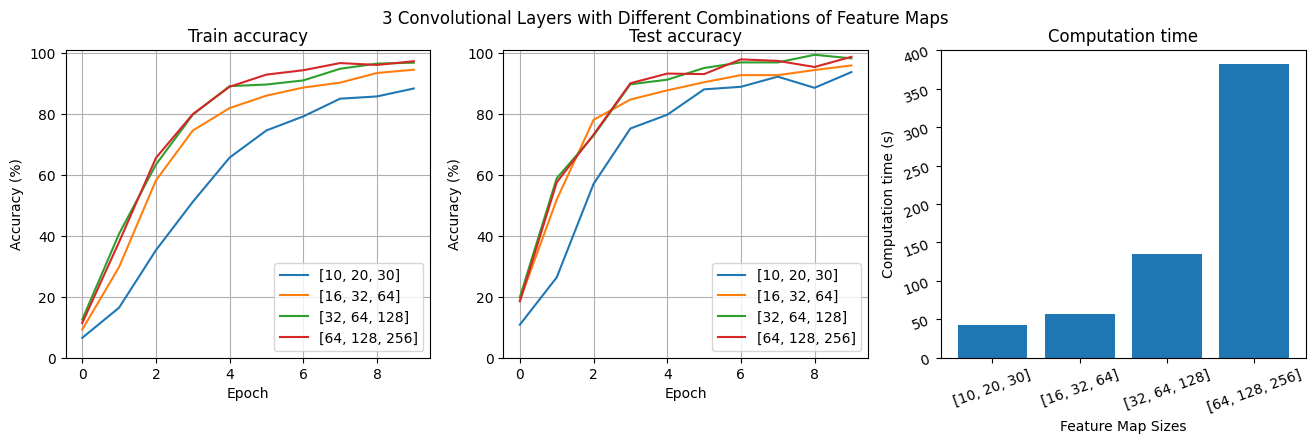

In [48]:
# Set the hyperparameters
# Input parameters
imageCount  = 3000  # Change the number of images here
batchsize   = 128   # adjustable
numepochs   = 10    # adjustable
learning_rate = 0.001   # adjustable
optimizer = 'Adam'  # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    # "feature": [10, 20, 30],    
    "kernel": [7, 5, 5],    # Convolutional layer (feature map, kernel_size, stride, padding)
    "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

# Initialize the testing feature maps
features = [[10, 20, 30], [16, 32, 64], [32, 64, 128], [64, 128, 256]]

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

# Create empty matrices to store training and testing accuracies, as well as computation times.
featureSize = len(features)
averageTrainAcc = np.zeros((numepochs, featureSize))
averageTestAcc = np.zeros((numepochs, featureSize))
finalTrainAcc = np.zeros(featureSize)
finalTestAcc = np.zeros(featureSize)
comptime = np.zeros(featureSize)

feature_label_list = []
for bi, test_case in enumerate(features):
    # Merge the dictionary with current case
    new_params = {**params, **{"feature": test_case}} 
    # Start the timer to measure computation time
    starttime = time.process_time()
    ''' Create a new model '''
    cnn = fruitCNN_Customizable(False,new_params)
    ''' Train CNN model '''
    trainAccList,testAccList,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
    # Save the labels of feature maps
    feature_label_list.append(str(test_case))

    finalTrainAcc[bi] = trainAccList[-1]
    finalTestAcc[bi] = testAccList[-1]
    # Store training and testing accuracy results
    averageTrainAcc[:, bi] = trainAccList
    averageTestAcc[:, bi] = testAccList

    # Record the computation time
    comptime[bi] = time.process_time() - starttime

# Print the overall accuracy for each batch
meanTrainAcc = np.mean(averageTrainAcc, axis=0)
meanTestAcc = np.mean(averageTestAcc, axis=0)


print("{:<18} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
    "Feature Maps", "Average Train Accuracy", "Final Train Accuracy", "Average Test Accuracy", "Final Test Accuracy", "Process Time"))
for i, batch in enumerate(feature_label_list):
    print("{:<18} {:<24} {:<24} {:<24} {:<24} {:<24}".format(
        feature_label_list[i], 
        "%.2f%%" % (meanTrainAcc[i]), "%.2f%%" % (finalTrainAcc[i]), 
        "%.2f%%" % (meanTestAcc[i]), "%.2f%%" % (finalTestAcc[i]), "%.2f Seconds" % (comptime[i])))

''' Plot the result '''
fig,ax = plt.subplots(1,3,figsize=(16,4))
fig.suptitle("3 Convolutional Layers with Different Combinations of Feature Maps")
ax[0].plot(averageTrainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(averageTestAcc)
ax[1].set_title('Test accuracy')
ax[2].bar(np.arange(0, len(comptime), 1, dtype=int),comptime,tick_label=feature_label_list)
ax[2].tick_params(rotation=20)
ax[2].set_xlabel('Feature Map Sizes')
ax[2].set_ylabel('Computation time (s)')
ax[2].set_title('Computation time')

# common features
for i in range(2):
    ax[i].legend(feature_label_list)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([0,101])
    ax[i].grid()
plt.show()


Feature map size of [16, 32, 64] and [32, 64, 128] are considerable.  
[16, 32, 64] has better computational performance. [32, 64, 128] has better accuracy.


### Find the Optimal Pooling Function and Pooling Kernel Size
Max pooling, with its emphasis on extracting dominant features and providing translation invariance, aligns well with the distinctive characteristics often present in fruit images.  
Pooling kernel size of 2x2 configuration is recommended. This choice strikes a balance between capturing fine-grained details and avoiding excessive downsampling, providing a suitable compromise for fruit classification tasks.

### Find the Optimal Hidden Layers and Nodes for Fully-Connected Layers

Best # of Layer is: 0 with the highest average accuracy of 96.31%.


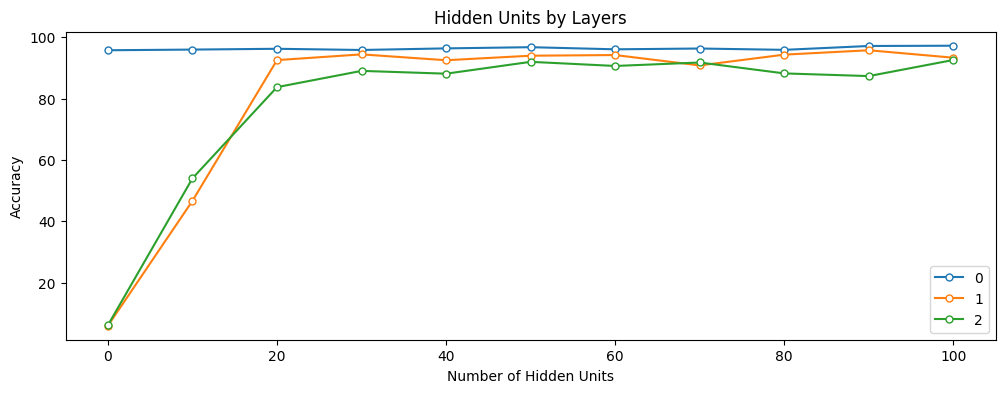

In [72]:
# Set the hyperparameters 
imageCount  = 3000  # Change the number of images here
numepochs   = 10    # adjustable
learning_rate = 0.001   # adjustable
optimizer = 'Adam'  # adjustable
batchsize   = 128   # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32, 64],# Convolutional layer (feature map, kernel_size, stride, padding)    
    "kernel": [7, 5, 5],    
    "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    # "fc_config": [50],      # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

# Define the model parameters: number of layers and number of units per layer.
numlayers = range(0, 3)             # Number of hidden layers.
numunits = np.arange(0, 101, 10)    # Units per hidden layer.
# Initialize matrices to store accuracies and total parameters.
accuracies = np.zeros((len(numunits), len(numlayers)))

# Start the experiment by varying the number of units and layers.
for uniti in range(len(numunits)):
    for layeri in range(len(numlayers)):
        # Merge the model configuerations. np.full(shape, fill_value) # a new array of given shape filled with fill_value
        new_params = {**params, **{"fc_config": np.full(numlayers[layeri], numunits[uniti], dtype=int).tolist()}} 
        ''' Create a new model '''
        cnn = fruitCNN_Customizable(False,new_params)
        ''' Train CNN model '''
        trainAccList,testAccList,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)
        # Store the accuracies
        accuracies[uniti, layeri] = trainAccList[-1]

accuracyList = np.mean(accuracies, axis=0)  
bestNumLayer = np.argmax(accuracyList)     
bestAcc = accuracyList[bestNumLayer]
print("Best # of Layer is: %d with the highest average accuracy of %.2f%%." % (bestNumLayer, bestAcc))
# Show accuracy as a function of the number of hidden units for different layers.
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=5)
ax.legend(numlayers)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Hidden Units')
ax.set_title('Hidden Units by Layers')
plt.show()


## Data Augmentation and Feature Analysis
For comprehensive data analysis, please refer to FruitClassification_FeatureAnalysis.ipynb

In [ ]:
# Set the hyperparameters 
imageCount  = 3000  # Change the number of images here
numepochs   = 10    # adjustable
learning_rate = 0.001   # adjustable
optimizer = 'Adam'  # adjustable
batchsize   = 128   # adjustable

# Default model configueration
params = {
    "inChannel": 3,         # Input channels (RGB 3 channels for images)
    "outClass": 33,         # Output class (fruit category)
    "imgsize": 100,         # Image size (100 x 100)
    "feature": [16, 32, 64],# Convolutional layer (feature map, kernel_size, stride, padding)    
    "kernel": [7, 5, 5],    
    "stride": [2, 1, 1],
    "padding": [1, 1, 1],
    "dropout_rate": 0.1,    # Dropout for convolutional layers
    "fc_config": [],        # Fully-connected layer structure
    "pooling": 'max',       # Pooling Function (avg-pool or  max-pool)
    "pooling_kernel": 2,    # Pooling kernel size
    }

''' Format Data '''
fruit_images, fruit_labels, fruit_names = formatData(dataset)
''' Normalize Data '''
fruit_images = normalizeData(fruit_images)
''' Resize Data '''
fruit_images, fruit_labels = resizeData(fruit_images, fruit_labels, imageCount)
''' Create TensorDataset '''
train_dataset, test_dataset = createTensorDataset(fruit_images, fruit_labels)
''' Create DataLoader in Batch'''
train_loader, test_loader = createDataLoaderInBatch(train_dataset, test_dataset, batchsize)

''' Create a new model '''
cnn = fruitCNN_Customizable(False,new_params)
''' Train CNN model '''
trainAccList,testAccList,losses,trained_cnn = trainCNNModel(cnn, train_loader, test_loader, numepochs, learning_rate, optimizer)

In [ ]:
# # data augmentation
# # https://pytorch.org/vision/stable/transforms.html
# imageTransform = v2.Compose([
#     # transforms.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
#     v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
#     v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
#     v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
#     # transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
#     # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
#     v2.ToPILImage(),  # Convert to PIL Image
#     # v2.ToTensor(),  # Converts the image to a PyTorch tensor and scale to [0 1] 
#     v2.ToImage(),   # v2.ToTensor is deprecated and will be removed in a future release. Use these instead
#     v2.ToDtype(tc.float32, scale=True),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
#     ])

# # Transfrom all the images in batch
# def transfromImageInBatch(data: np.ndarray):
#     img_shape = data[0].shape
#     trans_data = np.empty((0, *img_shape), dtype=np.uint8)
#     for i in range(len(data)):
#         image = imageTransform(data[i])
#         trans_data = np.append(trans_data, np.expand_dims(image, axis=0), axis=0)
#     return trans_data

# # trans_data = transfromImageInBatch(train_data)
# # print(type(trans_data))
# # print(trans_data.shape)

# trans_train_data = transfromImageInBatch(train_data)
# trans_test_data = transfromImageInBatch(test_data)

# trans_train_data  = tc.tensor( trans_train_data ).float()
# trans_test_data   = tc.tensor( trans_test_data ).float()

# trans_train_dataset = TensorDataset(train_data,train_labels)
# trans_test_dataset  = TensorDataset(test_data,test_labels)

# batchsize = 32
# trans_train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
# trans_test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


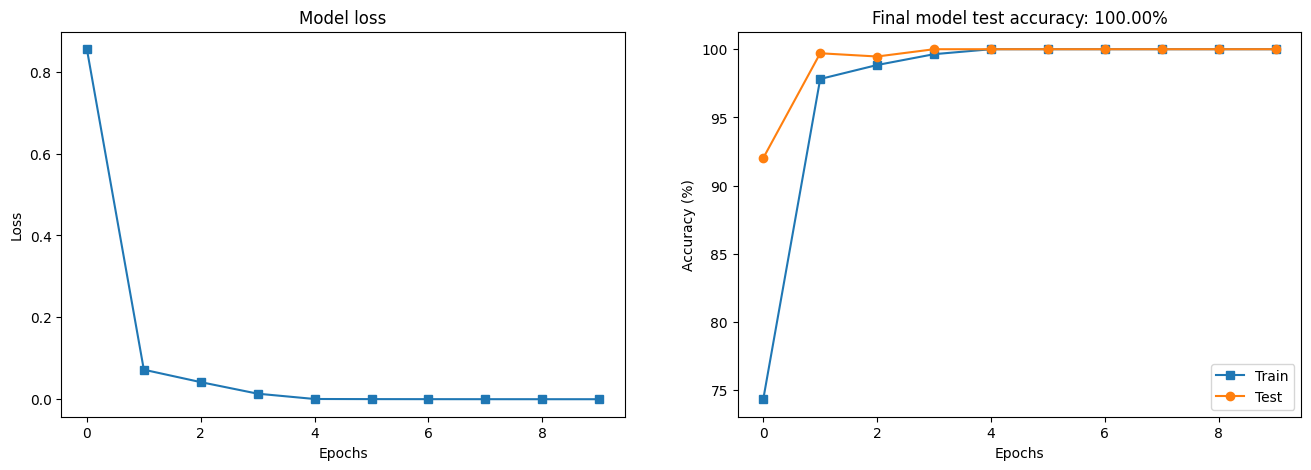

In [ ]:
# # Input parameters
# inChannel   = 3     # fixed value
# outChannel  = 33    # fixed value
# imgsize     = 100   # fixed value
# kernel      = 7     # adjustable
# stride      = 2     # adjustable
# padding     = 1     # adjustable
# numepochs   = 10    # adjustable
# learning_rate = 0.001    # adjustable

# # create a new model
# cnn = fruitCNN(False,kernel,stride,padding,inChannel,outChannel,imgsize)
# trainAcc,testAcc,losses,trained_cnn = trainCNNModel(cnn, trans_train_loader, trans_test_loader, numepochs, learning_rate)

# fig,ax = plt.subplots(1,2,figsize=(16,5))

# ax[0].plot(losses,'s-')
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Loss')
# ax[0].set_title('Model loss')

# ax[1].plot(trainAcc,'s-',label='Train')
# ax[1].plot(testAcc,'o-',label='Test')
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
# ax[1].legend()

# plt.show()

(3, 100, 100)
<class 'numpy.ndarray'>
torch.Size([3, 100, 100])
<class 'torchvision.tv_tensors._image.Image'>
torch.Size([100, 100, 3])


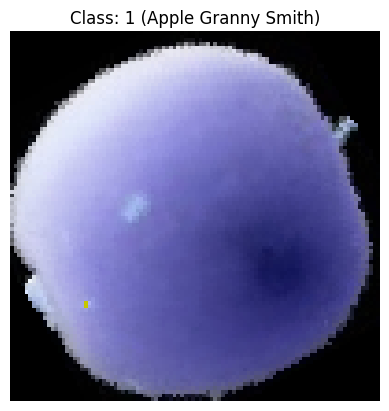

In [ ]:
# data augmentation
# https://pytorch.org/vision/stable/transforms.html
imageTransform = v2.Compose([
    # transforms.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    v2.ToPILImage(),  # Convert to PIL Image
    # v2.ToTensor(),  # Converts the image to a PyTorch tensor and scale to [0 1] 
    v2.ToImage(),   # v2.ToTensor is deprecated and will be removed in a future release. Use these instead
    v2.ToDtype(tc.float32, scale=True),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])
    
index = 600 # change the fruit index here to get a different fruit image (from 0 to 16853)
image = fruit_images[index]
label_idx = fruit_labels[index]
label_name = fruit_names[label_idx]
# Transpose the image data to (height, width, channels) format
# image = tc.tensor( image ).float()
print(image.shape) # (3, 100, 100)
print(type(image))
# image = np.transpose(image, (1, 2, 0))
# print(image.shape)
image = tc.tensor( image ).float() # (3, 100, 100)
print(image.shape)
image = imageTransform(image) # (3, 100, 100)
# print(image)
print(type(image))
image = image.permute(1, 2, 0)
print(image.shape)

# image = image.permute(1, 2, 0)
# Display the image (100, 100, 3)
plt.imshow(image)
plt.title(f"Class: {label_idx} ({label_name})")
plt.axis('off')
plt.show()